In [1]:
sst_dataset = {}
for split in ["train", "dev", "test"]:
    URL = f"https://raw.githubusercontent.com/successar/instance_attributions_NLP/master/Datasets/SST/data/{split}.jsonl"
    import urllib.request, json 
    with urllib.request.urlopen(URL) as url:
        data = url.read().decode()
        data = [json.loads(line) for line in data.strip().split("\n")]
        sst_dataset[split] = data

In [2]:
import numpy as np
from tqdm import tqdm

In [3]:
import spacy 
nlp = spacy.load('en_core_web_md')

# We use spacy to get feature vectors for our input text.

In [4]:
import numpy as np
from tqdm import tqdm
X, y = {}, {}
for split in ["train", "dev"]:
    X[split] = np.array([nlp(example["document"]).vector for example in tqdm(sst_dataset[split])])
    y[split] = np.array([example["label"] for example in sst_dataset[split]])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:05<00:00, 154.25it/s]


In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=1)
model.fit(X["train"], y["train"])
model.score(X["dev"], y["dev"])

0.7924311926605505

In [6]:
w = np.concatenate((model.coef_, model.intercept_[None, :]), axis=1)
F_train = np.concatenate([X["train"], np.ones((X["train"].shape[0], 1))], axis=1) # Concatenating one to calculate the gradient with respect to intercept
F_dev = np.concatenate([X["dev"], np.ones((X["dev"].shape[0], 1))], axis=1)

error_train = model.predict_proba(X["train"])[:, 1] - y["train"]
error_dev = model.predict_proba(X["dev"])[:, 1] - y["dev"]

gradient_train = F_train * error_train[:, None] +  w /X["train"].shape[0]
gradient_dev = F_dev * error_dev[:, None] +  w / X["train"].shape[0]
gradient_train.shape, gradient_dev.shape

((6920, 301), (872, 301))

In [7]:
from scipy import sparse
probs = model.predict_proba(X["train"])[:, 1]
hessian = F_train.T @ np.diag(probs * (1 - probs)) @ F_train / X["train"].shape[0] + 1 * np.eye(F_train.shape[1]) / X["train"].shape[0]
inverse_hessian = np.linalg.inv(hessian)

In [8]:
eps = 1 / X["train"].shape[0]
delta_k = -eps * inverse_hessian @ gradient_train.T
pred = np.reshape(model.predict_proba(X["dev"])[:, 1], (model.predict_proba(X["dev"])[:, 1].shape[0], 1))
grad_f = F_dev * (pred * (1 - pred))
delta_pred = grad_f @ delta_k
delta_pred.shape

(872, 6920)

In [39]:
def Remove(k, scores, test_idx):
    #print("test_idx", test_idx)
    #print("old")
    #print(pred[test_idx])
    
    if pred[test_idx] > 0.5:
        top_k_index = scores[test_idx].argsort()[-k:]
    else:
        top_k_index = scores[test_idx].argsort()[:k]

    X_k = np.delete(X["train"], top_k_index, axis=0)
    y_k = np.delete(y["train"], top_k_index, axis=0)

        
    prediction = -np.sum(scores[test_idx][top_k_index])
    #print("prediction", prediction)

    return X_k, y_k, prediction

In [51]:
def new_train(k, dev_index, scores):
    X_k, y_k, prediction = Remove(k, scores, dev_index)

    # Fit the model again
    model_k = LogisticRegression(penalty='l2', C=1)
    model_k.fit(X_k, y_k)

    # predictthe probaility with test point
    test_item = sst_dataset["dev"][dev_index]
    test_point = X["dev"][dev_index]
    test_point=np.reshape(test_point, (1,-1))

    change = -(model.predict_proba(test_point)[0][1] - model_k.predict_proba(test_point)[0][1])
    #change = model_k.predict_proba(test_point)[0][1]-model.predict_proba(test_point)[0][1]
    flip = (model.predict(test_point) == model_k.predict(test_point))
    
    #print("change    ", change)
    #print("old       ", model.predict_proba(test_point)[0][1])
    #print()
    
  
    return change, flip, prediction

# exact k

In [158]:
def exact_k(test_idx):
    for k in range(1, np.sum(y["train"])):
        _, flip,_ = new_train(k, test_idx, delta_pred)
        if flip == False:
            return k
    return None

In [159]:
# Loop over all dev points:
import warnings
warnings.filterwarnings("ignore")

exact_ks = []
for test_idx in range(X["dev"].shape[0]):
    k =exact_k(test_idx)
    print(test_idx, k)
    exact_ks.append(k)

exact_ks=np.array(exact_ks)
np.save("exact_ks_IP.npy", exact_ks)

KeyboardInterrupt: 

# Find approximate k by IF

In [30]:
def pred_change(k, scores, test_idx):
    X_k, y_k, prediction = Remove(k, delta_pred, test_idx)
    

In [41]:
def approximate_k(test_idx):
    old = pred[test_idx].item()
    for k in range(1, np.sum(y["train"])):
        _, _, change = Remove(k, delta_pred, test_idx)
        #_, flip,_ = new_train(k, test_idx, delta_pred)
        
        if old > 0.5 and change <-0.5:
            return k
        elif old < 0.5 and change > 0.5:
            return k
        
    return None

In [42]:
# Loop over all dev points:
appro_ks = []
for test_idx in range(X["dev"].shape[0]):
    appro_k = approximate_k(test_idx)
    print(test_idx, appro_k)
    print()
    appro_ks.append(appro_k)

0 None

1 204

2 None

3 None

4 None

5 None

6 None

7 203

8 398

9 345

10 1092

11 282

12 603

13 921

14 172

15 266

16 404

17 212

18 None

19 None

20 268

21 None

22 462

23 None

24 None

25 None

26 369

27 288

28 220

29 172

30 None

31 138

32 142

33 213

34 None

35 None

36 189

37 210

38 253

39 349

40 None

41 213

42 452

43 None

44 987

45 None

46 1132

47 358

48 None

49 None

50 186

51 None

52 181

53 117

54 None

55 169

56 None

57 144

58 129

59 258

60 1073

61 662

62 668

63 None

64 797

65 None

66 617

67 161

68 None

69 285

70 309

71 676

72 None

73 None

74 223

75 None

76 245

77 657

78 510

79 135

80 None

81 None

82 None

83 1126

84 162

85 185

86 None

87 None

88 1952

89 684

90 1019

91 364

92 273

93 103

94 228

95 133

96 None

97 2448

98 493

99 None

100 293

101 None

102 448

103 None

104 228

105 None

106 104

107 509

108 380

109 238

110 600

111 166

112 100

113 152

114 214

115 1150

116 493

117 162

1

In [43]:
appro_ks= np.array(appro_ks)
np.save("appro_ks_IP.npy", appro_ks)

# Difference of change and prediction when k increasing

In [151]:
row = len(list(range(0, X["dev"].shape[0], 30)))
col = len(list(range(1, 500, 10)))
changes = np.zeros((row, col))
prediction = np.zeros((row, col))

for i in range(0, X["dev"].shape[0], 30):
    print(i)
    for j in range(1, 500, 10):
        changes[int(i / 30), int(j/10)], _, prediction[int(i / 10), int(j/10)] = new_train(j, i, delta_pred)

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870


In [155]:
difference = prediction - changes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


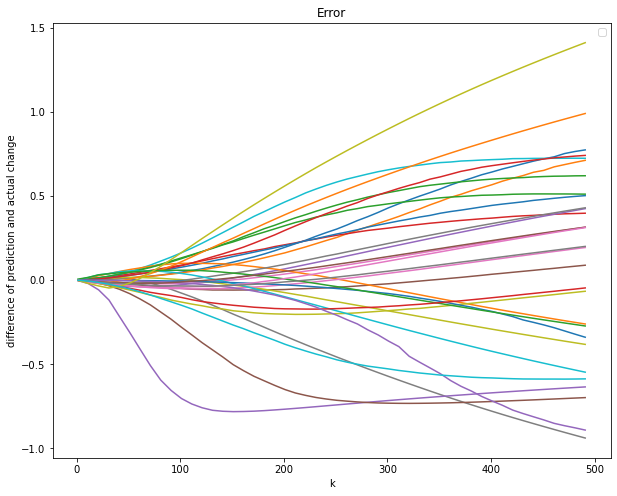

In [156]:
"""
plt.figure(figsize=(10, 8))
plt.plot(K, difference.T)
plt.legend()
plt.xlabel("k")
plt.ylabel("difference of prediction and actual change")
plt.title("Error")
plt.show()
"""

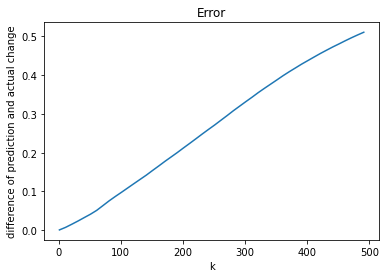

In [157]:
"""
mean_diff = np.mean(np.abs(difference), axis=0)
plt.plot(K, mean_diff)
plt.xlabel("k")
plt.ylabel("difference of prediction and actual change")
plt.title("Error")
plt.show()
'''

In [160]:
np.save("mean_diff.npy", mean_diff)

# correlation k with pred

In [14]:
exact_k = np.load("exact_ks_IP.npy")[:, None]

In [15]:
exact_k.shape

(872, 1)

In [16]:
pred.shape

(872, 1)

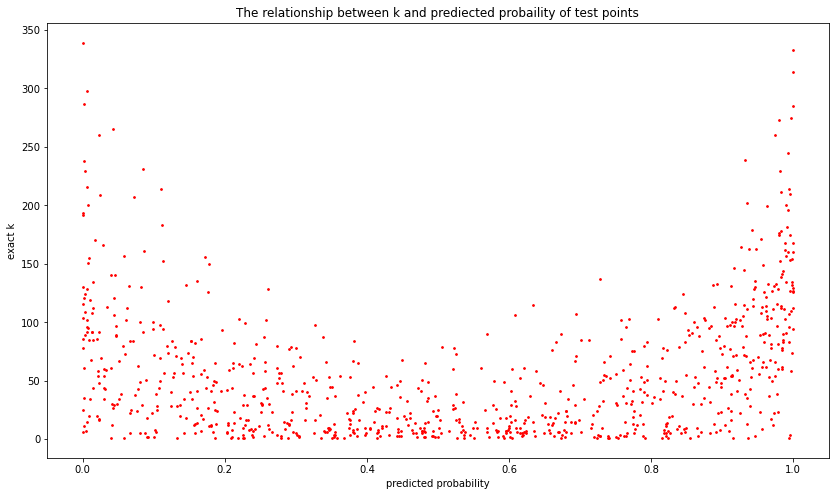

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.scatter(pred, exact_k, s=3, color='red')

plt.title("The relationship between k and prediected probaility of test points")
plt.xlabel("predicted probability")
plt.ylabel("exact k")
plt.show()

In [24]:
dis = np.array([np.abs(i - 0.5) for i in pred])

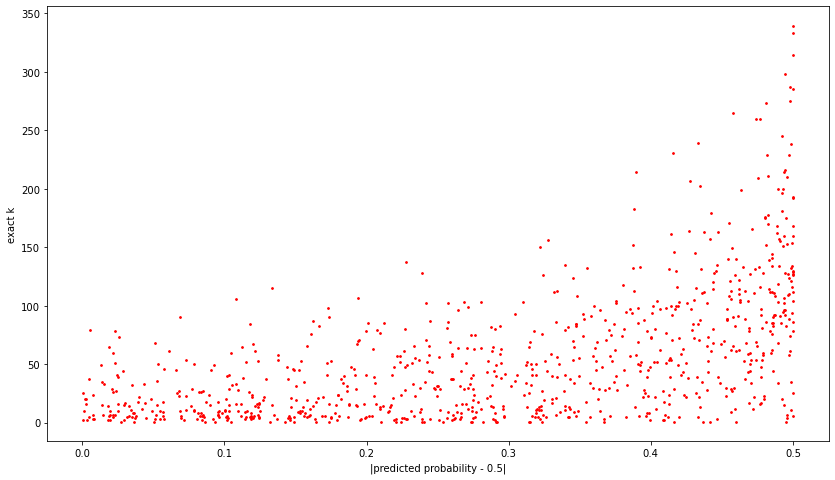

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.scatter(dis, exact_k, s=3, color='red')
 
plt.xlabel("|predicted probability - 0.5|")
plt.ylabel("exact k")
plt.show()

In [30]:
np.corrcoef(dis.squeeze(), exact_k.squeeze())

array([[1.        , 0.55972908],
       [0.55972908, 1.        ]])